In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
from datetime import datetime
from ipywidgets import interact, IntSlider, Checkbox, HBox, VBox, Button, Output, Layout  # 添加Layout导入
from IPython.display import display, clear_output
import matplotlib.dates as mdates

# 配置Tushare
def configure_tushare(token: str = "48214906a56d6318dd8a7315f934ef249f9a033ccf82bd04a65e6ded") -> ts.pro_api:
    ts.set_token(token)
    return ts.pro_api()

pro = configure_tushare()
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

class InvestmentStrategyAnalyzer:
    """双维度投资策略分析工具"""
    def __init__(self, base_asset: str, targets: dict):
        self.base_asset = base_asset
        self.targets = targets
        self.combined = None
        self.base_name = self.targets[base_asset][1]
        self.current_chart_data = None
        
    def load_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """加载市场数据"""
        data_dict = {}
        
        # 加载基准资产
        base_code, _, base_type = self.targets[self.base_asset]
        base_data = self._get_asset_data(base_code, start_date, end_date, base_type)
        if base_data is None:
            raise ValueError(f"基准资产加载失败: {self.base_name}({base_code})")
        data_dict[self.base_asset] = base_data
        
        # 加载目标资产
        for key, (code, name, atype) in self.targets.items():
            if key == self.base_asset:
                continue
                
            asset_data = self._get_asset_data(code, start_date, end_date, atype)
            if asset_data is not None:
                data_dict[key] = asset_data
            else:
                print(f"⚠️ 警告: {name}({code}) 数据加载失败")
        
        self.combined = pd.concat({k: v['close'] for k, v in data_dict.items()}, axis=1)
        print(f"✓ 数据加载完成: {len(data_dict)-1}个行业ETF")
        return self.combined
    
    def _get_asset_data(self, ts_code: str, start_date: str, end_date: str, asset_type: str = 'ETF') -> pd.DataFrame:
        """统一数据获取接口"""
        try:
            func = pro.fund_daily if asset_type == 'ETF' else pro.index_daily
            df = func(ts_code=ts_code, start_date=start_date, end_date=end_date)
            
            if df.empty:
                return None
                
            # 数据处理
            df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            df.set_index('trade_date', inplace=True)
            df.sort_index(inplace=True)
            return df[['close']]
        except Exception as e:
            print(f"数据获取异常: {ts_code}, {str(e)}")
            return None
            
    def calculate_ratios(self) -> "InvestmentStrategyAnalyzer":
        """计算投资标的相对于基准的比价关系"""
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        
        for target in targets_list:
            ratio_col = f"{target}_VS_{self.base_asset}"
            self.combined[ratio_col] = self.combined[target] / self.combined[self.base_asset]
            
            # 计算不同周期的移动平均
            for window in [5, 10, 20, 30]:
                ma_col = f"{ratio_col}_MA{window}"
                self.combined[ma_col] = self.combined[ratio_col].rolling(window).mean()
                
        return self
    
    def create_multi_ma_strategy_chart(self):
        """创建多均线策略交互图表"""
        # 创建输出区域
        out = Output(layout={'border': '1px solid silver'})
        display(out)
        
        # 创建保存PDF按钮
        pdf_btn = Button(description="保存图表为PDF", 
                         button_style='info',
                         tooltip="将当前视图保存为PDF文件",
                         layout=Layout(width='150px'))

        def save_as_pdf(b):
            """保存图表为PDF"""
            with out:
                if self.current_chart_data is None:
                    print("⚠️ 请先生成图表")
                    return
                
                # 生成文件名 - 保存在当前目录
                date_str = datetime.now().strftime("%Y%m%d_%H%M")
                filename = f"多均线策略_{date_str}.pdf"
                filepath = os.path.join(os.getcwd(), filename)
                
                # 生成图表并保存
                fig = self.current_chart_data['figure']
                fig.savefig(filepath, bbox_inches='tight', dpi=150)
                print(f"✓ 图表已保存至: {filepath}")
        
        pdf_btn.on_click(save_as_pdf)
        
        def plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        ):
            """绘制多均线策略图表"""
            # 收集需要显示的资产 - 显示除基准外的所有资产
            targets_list = [k for k in self.targets.keys() if k != self.base_asset]
            if not targets_list:
                with out:
                    print("⚠️ 没有可用的行业数据")
                return
                    
            with out:
                clear_output(wait=True)
                
                # 根据ETF数量动态调整图幅高度
                fig_height = max(5, min(len(targets_list) * 5, 35))  # 限制在5-35英寸之间
                fig = plt.figure(figsize=(14, fig_height))
                
                data = self.combined.iloc[-period:]
                
                for idx, asset in enumerate(targets_list):
                    ratio_col = f"{asset}_VS_{self.base_asset}"
                    asset_name = self.targets[asset][1]
                    
                    # 动态调整子图布局
                    rows = (len(targets_list) + 1) // 2
                    cols = 2 if len(targets_list) > 1 else 1
                    ax = plt.subplot(rows, cols, idx+1)
                    
                    # 绘制比价曲线（作为背景参考）
                    ax.plot(
                        data.index,
                        data[ratio_col],
                        color='gray',
                        linewidth=0.8,
                        alpha=0.3
                    )
                    
                    # 绘制5/10/30日均线
                    ma_colors = {'ma5': 'orangered', 'ma10': 'royalblue', 'ma30': 'purple'}
                    ma_settings = [
                        (show_ma5, 5, ma_colors['ma5']),
                        (show_ma10, 10, ma_colors['ma10']),
                        (show_ma30, 30, ma_colors['ma30'])
                    ]
                    
                    for show, window, color in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ax.plot(
                                data.index,
                                data[ma_col],
                                label=f'{window}日均线',
                                color=color,
                                linewidth=2.0
                            )
                    
                    # 图表美化
                    ax.set_title(f'{asset_name}', fontsize=11)
                    ax.grid(alpha=0.2, linestyle=':')
                    
                    # 添加图例
                    handles, labels = ax.get_legend_handles_labels()
                    if handles:  # 仅当有图例项时添加
                        ax.legend(loc='best', fontsize=9, framealpha=0.7)
                    
                    # 格式日期坐标轴
                    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
                    locator = mdates.MonthLocator(interval=3) if period > 180 else mdates.MonthLocator(interval=1)
                    ax.xaxis.set_major_locator(locator)
                    
                    # 标注当前最新值
                    current_val = data[ratio_col].iloc[-1]
                    current_value_text = f'当前比价: {current_val:.4f}'
                    
                    # 添加各均线最新值
                    value_labels = [current_value_text]
                    for show, window, _ in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ma_val = data[ma_col].iloc[-1]
                            value_labels.append(f'{window}日: {ma_val:.4f}')
                    
                    final_label = '\n'.join(value_labels)
                    ax.annotate(
                        final_label,
                        xy=(0.97, 0.95),
                        xycoords='axes fraction',
                        ha='right',
                        va='top',
                        fontsize=9,
                        bbox=dict(facecolor='lightyellow', alpha=0.7, edgecolor='none')
                    )
                
                base_title = (
                    f"行业ETF多均线策略分析 (基准: {self.base_name}, 周期: {period}天)" if period != 250 
                    else f"行业ETF多均线策略分析 (基准: {self.base_name})"
                )
                
                plt.suptitle(base_title, fontsize=14, fontweight='bold', y=0.98)
                plt.tight_layout(rect=[0, 0.01, 1, 0.96])
                plt.show()
                print("✓ 图表已生成！可点击下方按钮保存为PDF")
                self.current_chart_data = {
                    'period': period,
                    'figure': fig,
                    'settings': {'ma5': show_ma5, 'ma10': show_ma10, 'ma30': show_ma30}
                }
        
        # 创建控制面板
        controls = VBox([
            HBox([
                IntSlider(min=60, max=500, step=5, value=250, 
                         description='分析周期:', layout=Layout(width='300px')),
                pdf_btn
            ]),
            HBox([
                Checkbox(value=True, description='5日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='10日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='30日均线', layout=Layout(width='100px'))
            ])
        ])
        
        # 显示控件并设置初始显示
        display(controls)
        
        # 初始绘制图表
        plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        )
        
        # 设置交互函数
        interact(
            plot_multi_ma_strategy,
            period=controls.children[0].children[0],
            show_ma5=controls.children[1].children[0],
            show_ma10=controls.children[1].children[1],
            show_ma30=controls.children[1].children[2]
        )
    
    def generate_20ma_strategy(self):b
        """生成20日均线策略报告"""
        print(">>> 生成20日均线策略报告 <<<")
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        num_targets = len(targets_list)
        
        if num_targets == 0:
            print("⚠️ 没有可分析的目标资产")
            return None
            
        # 创建图表
        cols = 3  # 改为3列布局以适应更多ETF
        rows = (num_targets + cols - 1) // cols
        fig = plt.figure(figsize=(18, 4.5 * rows))
        
        # 为每个资产创建子图
        for idx, asset in enumerate(targets_list):
            ratio_col = f"{asset}_VS_{self.base_asset}"
            asset_name = self.targets[asset][1]
            
            # 确定子图位置
            ax = plt.subplot(rows, cols, idx + 1)
            data = self.combined.iloc[-250:]
            
            # 绘制比价曲线
            ax.plot(
                data.index,
                data[ratio_col],
                label=f'{asset_name}比价',
                color='steelblue',
                linewidth=1.8
            )
            
            # 绘制20日均线
            ma_col = f"{ratio_col}_MA20"
            ax.plot(
                data.index,
                data[ma_col],
                label='20日均线',
                color='darkorange',
                linewidth=2.0,
                linestyle='--'
            )
            
            # 图表元素
            current_val = data[ratio_col].iloc[-1]
            current_ma = data[ma_col].iloc[-1]
            above_ma = "在20日均线上方" if current_val > current_ma else "在20日均线下方"
            
            # 添加当前值和20日均线值标注
            ax.annotate(
                f'{current_val:.4f}\n{current_ma:.4f}',
                xy=(0.97, 0.95),
                xycoords='axes fraction',
                ha='right',
                fontsize=9,
                bbox=dict(facecolor='wheat', alpha=0.5, edgecolor='none')
            )
            
            # 趋势方向指示
            ax.annotate(
                f'{above_ma}',
                xy=(0.03, 0.02),
                xycoords='axes fraction',
                ha='left',
                fontsize=9,
                fontweight='bold',
                bbox=dict(facecolor=('lightgreen' if above_ma == "在20日均线上方" else 'lightcoral'), 
                          alpha=0.7, edgecolor='none')
            )
            
            ax.set_title(f'{asset_name}', fontsize=10, pad=8)
            ax.grid(True, linestyle=':', alpha=0.3)
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            
            # 仅底部图表添加图例
            if idx % cols == (cols - 1) or idx == len(targets_list) - 1:
                ax.legend(fontsize=8, loc='lower center')
        
        plt.suptitle(
            f"20日移动平均策略分析 - {self.base_name}基准",
            fontsize=15,
            fontweight='bold'
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # 保存报告 - 直接保存在当前目录
        date_str = datetime.now().strftime("%Y%m%d")
        filepath = os.path.join(os.getcwd(), f"20日均线策略报告_{date_str}.pdf")
        fig.savefig(filepath, bbox_inches='tight')
        print(f"✓ 20日均线策略报告已保存至: {filepath}")
        
        plt.show()

# 主执行流程
if __name__ == "__main__":
    # 1. 参数配置
    start_date = '20241001'  # 调整为更近的起始日期
    end_date = datetime.now().strftime('%Y%m%d')
    
    # 2. 资产配置（沪深300ETF作为基准）
    targets = {
        'HS300': ('510300.SH', '沪深300', 'ETF'),  # 基准资产
        
        # 更新行业ETF列表
        'CHIP_ETF': ('159995.SZ', '芯片ETF', 'ETF'),
        'SEMIS': ('512480.SH', '半导体ETF', 'ETF'),
        'PV_ETF': ('515790.SH', '光伏ETF', 'ETF'),
        'SOFTWARE_ETF': ('515230.SH', '软件ETF', 'ETF'),
        'SECURITY_ETF': ('512880.SH', '证券ETF', 'ETF'),
        'MILITARY_ETF': ('512660.SH', '军工ETF', 'ETF'),
        'MED_ETF': ('512010.SH', '医药ETF', 'ETF'),
        'HC': ('512170.SH', '医疗ETF', 'ETF'),
        'REALSTATE_ETF': ('512200.SH', '房地产ETF', 'ETF'),
        'WINE_ETF': ('512690.SH', '酒ETF', 'ETF'),
        'TRAVEL_ETF': ('562510.SH', '旅游ETF', 'ETF'),
        'MEDIA_ETF': ('512980.SH', '传媒ETF', 'ETF'),
        'ESG_ETF': ('512760.SH', '环保ETF', 'ETF'),
        'DI_DIVIDEND': ('512890.SH', '低波ETF', 'ETF'),
        'DIVIDEND_ETF': ('515180.SH', '红利ETF', 'ETF')
    }
    
    # 3. 初始化分析器
    print(">>> 启动双策略投资分析系统 <<<")
    analyzer = InvestmentStrategyAnalyzer(base_asset='HS300', targets=targets)
    
    # 4. 加载数据
    print("\n>>> 加载市场数据 <<<")
    analyzer.load_data(start_date, end_date)
    analyzer.calculate_ratios()
    
    # 5. 生成多均线交互式图表
    print("\n>>> 创建多均线策略交互视图 <<<")
    analyzer.create_multi_ma_strategy_chart()
    
    # 6. 生成20日均线策略报告
    print("\n>>> 生成20日均线交易策略 <<<")
    analyzer.generate_20ma_strategy()
    
    print("\n>>> 投资分析完成 <<<")


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
from datetime import datetime
from ipywidgets import interact, IntSlider, Checkbox, HBox, VBox, Button, Output, Layout
from IPython.display import display, clear_output
import matplotlib.dates as mdates

# 配置Tushare
def configure_tushare(token: str = "48214906a56d6318dd8a7315f934ef249f9a033ccf82bd04a65e6ded") -> ts.pro_api:
    ts.set_token(token)
    return ts.pro_api()

pro = configure_tushare()
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

class InvestmentStrategyAnalyzer:
    """双维度投资策略分析工具"""
    def __init__(self, base_asset: str, targets: dict):
        self.base_asset = base_asset
        self.targets = targets
        self.combined = None
        self.base_name = self.targets[base_asset][1]
        self.current_chart_data = None
        
    def load_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """加载市场数据"""
        data_dict = {}
        loaded_assets = []

        # 打印当前配置的资产列表
        print("\n===== 配置的资产列表 =====")
        for key, (code, name, atype) in self.targets.items():
            print(f"{name} [{atype}]: {code}")
            loaded_assets.append(name)
        
        # 加载基准资产
        base_code, _, base_type = self.targets[self.base_asset]
        base_data = self._get_asset_data(base_code, start_date, end_date, base_type)
        if base_data is None:
            raise ValueError(f"基准资产加载失败: {self.base_name}({base_code})")
        data_dict[self.base_asset] = base_data
        
        # 加载目标资产
        for key, (code, name, atype) in self.targets.items():
            if key == self.base_asset:
                continue
                
            asset_data = self._get_asset_data(code, start_date, end_date, atype)
            if asset_data is not None:
                data_dict[key] = asset_data
            else:
                print(f"⚠️ 警告: {name}({code}) 数据加载失败")
        
        self.combined = pd.concat({k: v['close'] for k, v in data_dict.items()}, axis=1)
        
        # 打印成功加载的资产列表
        print("\n===== 成功加载的资产列表 =====")
        for asset in data_dict:
            print(f"{self.targets[asset][1]} ({asset}): {self.targets[asset][0]}")
            
        print(f"\n✓ 数据加载完成: {len(data_dict)-1}个行业ETF")
        return self.combined
    
    def _get_asset_data(self, ts_code: str, start_date: str, end_date: str, asset_type: str = 'ETF') -> pd.DataFrame:
        """统一数据获取接口"""
        try:
            func = pro.fund_daily if asset_type == 'ETF' else pro.index_daily
            df = func(ts_code=ts_code, start_date=start_date, end_date=end_date)
            
            if df.empty:
                print(f"⚠️ 没有获取到{ts_code}的数据")
                return None
                
            # 数据处理
            df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            df.set_index('trade_date', inplace=True)
            df.sort_index(inplace=True)
            return df[['close']]
        except Exception as e:
            print(f"数据获取异常: {ts_code}, {str(e)}")
            return None
            
    def calculate_ratios(self) -> "InvestmentStrategyAnalyzer":
        """计算投资标的相对于基准的比价关系"""
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        
        for target in targets_list:
            ratio_col = f"{target}_VS_{self.base_asset}"
            self.combined[ratio_col] = self.combined[target] / self.combined[self.base_asset]
            
            # 计算不同周期的移动平均
            for window in [5, 10, 20, 30]:
                ma_col = f"{ratio_col}_MA{window}"
                self.combined[ma_col] = self.combined[ratio_col].rolling(window).mean()
                
        return self
    
    def create_multi_ma_strategy_chart(self):
        """创建多均线策略交互图表"""
        # 创建输出区域
        out = Output(layout={'border': '1px solid silver'})
        display(out)
        
        # 创建保存PDF按钮
        pdf_btn = Button(description="保存图表为PDF", 
                         button_style='info',
                         tooltip="将当前视图保存为PDF文件",
                         layout=Layout(width='150px'))

        def save_as_pdf(b):
            """保存图表为PDF"""
            with out:
                if self.current_chart_data is None:
                    print("⚠️ 请先生成图表")
                    return
                
                # 生成文件名 - 保存在当前目录
                date_str = datetime.now().strftime("%Y%m%d_%H%M")
                filename = f"多均线策略_{date_str}.pdf"
                filepath = os.path.join(os.getcwd(), filename)
                
                # 生成图表并保存
                fig = self.current_chart_data['figure']
                fig.savefig(filepath, bbox_inches='tight', dpi=150)
                print(f"✓ 图表已保存至: {filepath}")
        
        pdf_btn.on_click(save_as_pdf)
        
        def plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        ):
            """绘制多均线策略图表"""
            # 收集需要显示的资产 - 显示除基准外的所有资产
            targets_list = [k for k in self.targets.keys() if k != self.base_asset]
            if not targets_list:
                with out:
                    print("⚠️ 没有可用的行业数据")
                return
                    
            with out:
                clear_output(wait=True)
                
                # 根据ETF数量动态调整图幅高度
                fig_height = max(5, min(len(targets_list) * 5, 35))  # 限制在5-35英寸之间
                fig = plt.figure(figsize=(14, fig_height))
                
                data = self.combined.iloc[-period:]
                
                for idx, asset in enumerate(targets_list):
                    ratio_col = f"{asset}_VS_{self.base_asset}"
                    asset_name = self.targets[asset][1]
                    
                    # 动态调整子图布局
                    rows = (len(targets_list) + 1) // 2
                    cols = 2 if len(targets_list) > 1 else 1
                    ax = plt.subplot(rows, cols, idx+1)
                    
                    # 绘制比价曲线（作为背景参考）
                    ax.plot(
                        data.index,
                        data[ratio_col],
                        color='gray',
                        linewidth=0.8,
                        alpha=0.3,
                        zorder=1  # 确保在底层
                    )
                    
                    # 绘制5/10/30日均线
                    ma_colors = {'ma5': 'orangered', 'ma10': 'royalblue', 'ma30': 'purple'}
                    ma_settings = [
                        (show_ma5, 5, ma_colors['ma5']),
                        (show_ma10, 10, ma_colors['ma10']),
                        (show_ma30, 30, ma_colors['ma30'])
                    ]
                    
                    plot_lines = []  # 记录绘制的均线
                    for show, window, color in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            line, = ax.plot(
                                data.index,
                                data[ma_col],
                                label=f'{window}日均线',
                                color=color,
                                linewidth=2.0,
                                zorder=2  # 确保在上层
                            )
                            plot_lines.append(line)
                    
                    # 图表美化
                    ax.set_title(f'{asset_name}', fontsize=11)
                    ax.grid(alpha=0.2, linestyle=':')
                    
                    # 添加图例 - 智能位置判定优化
                    if plot_lines:
                        # 确定当前图表的相对位置
                        is_top = idx < cols
                        is_right = (idx + 1) % cols == 0 or (cols == 1)
                        
                        # 根据图表位置智能选择图例位置
                        if is_top and is_right:
                            loc = 'lower left'  # 右上方图表用左下角位置
                        elif is_top:
                            loc = 'lower right'  # 左上方图表用右下角位置
                        elif is_right:
                            loc = 'upper right'  # 右下方图表用右上角位置
                        else:
                            loc = 'upper left'   # 左下方图表用左上角位置
                        
                        # 添加图例
                        ax.legend(handles=plot_lines, loc=loc, fontsize=9, framealpha=0.7)
                    
                    # 格式日期坐标轴
                    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
                    locator = mdates.MonthLocator(interval=3) if period > 180 else mdates.MonthLocator(interval=1)
                    ax.xaxis.set_major_locator(locator)
                    
                    # 标注当前最新值
                    current_val = data[ratio_col].iloc[-1]
                    current_value_text = f'当前比价: {current_val:.4f}'
                    
                    # 计算均线位置信息用于风险提示
                    above_ma_count = 0
                    value_labels = [current_value_text]
                    for show, window, _ in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ma_val = data[ma_col].iloc[-1]
                            value_labels.append(f'{window}日: {ma_val:.4f}')
                            if current_val > ma_val:
                                above_ma_count += 1
                        
                    # 添加风险水平提示
                    risk_level = ""
                    if above_ma_count >= 2:
                        risk_level = "趋势偏强"
                        risk_color = 'forestgreen'
                    elif above_ma_count == 1:
                        risk_level = "中性区间"
                        risk_color = 'goldenrod'
                    else:
                        risk_level = "偏弱区域"
                        risk_color = 'lightcoral'
                        
                    final_label = '\n'.join(value_labels)
                    ax.annotate(
                        final_label,
                        xy=(0.97, 0.95),
                        xycoords='axes fraction',
                        ha='right',
                        va='top',
                        fontsize=9,
                        bbox=dict(facecolor='lightyellow', alpha=0.7, edgecolor='none')
                    )
                    
                    # 添加风险水平提示
                    ax.annotate(
                        f'风险水平: {risk_level}',
                        xy=(0.03, 0.02),
                        xycoords='axes fraction',
                        ha='left',
                        fontsize=9,
                        fontweight='bold',
                        bbox=dict(facecolor=risk_color, alpha=0.7, edgecolor='none')
                    )
                
                base_title = (
                    f"行业ETF多均线策略分析 (基准: {self.base_name}, 周期: {period}天)" if period != 250 
                    else f"行业ETF多均线策略分析 (基准: {self.base_name})"
                )
                
                plt.suptitle(base_title, fontsize=14, fontweight='bold', y=0.98)
                plt.tight_layout(rect=[0, 0.01, 1, 0.96])
                plt.show()
                print("✓ 图表已生成！可点击下方按钮保存为PDF")
                self.current_chart_data = {
                    'period': period,
                    'figure': fig,
                    'settings': {'ma5': show_ma5, 'ma10': show_ma10, 'ma30': show_ma30}
                }
        
        # 创建控制面板
        controls = VBox([
            HBox([
                IntSlider(min=60, max=500, step=5, value=250, 
                         description='分析周期:', layout=Layout(width='300px')),
                pdf_btn
            ]),
            HBox([
                Checkbox(value=True, description='5日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='10日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='30日均线', layout=Layout(width='100px'))
            ])
        ])
        
        # 显示控件并设置初始显示
        display(controls)
        
        # 初始绘制图表
        plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        )
        
        # 设置交互函数
        interact(
            plot_multi_ma_strategy,
            period=controls.children[0].children[0],
            show_ma5=controls.children[1].children[0],
            show_ma10=controls.children[1].children[1],
            show_ma30=controls.children[1].children[2]
        )
    
    def generate_20ma_strategy(self):
        """生成20日均线策略报告"""
        print(">>> 生成20日均线策略报告 <<<")
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        num_targets = len(targets_list)
        
        if num_targets == 0:
            print("⚠️ 没有可分析的目标资产")
            return None
            
        # 创建图表
        cols = 3  # 改为3列布局以适应更多ETF
        rows = (num_targets + cols - 1) // cols
        fig = plt.figure(figsize=(18, 4.5 * rows))
        
        # 为每个资产创建子图
        for idx, asset in enumerate(targets_list):
            ratio_col = f"{asset}_VS_{self.base_asset}"
            asset_name = self.targets[asset][1]
            
            # 确定子图位置
            ax = plt.subplot(rows, cols, idx + 1)
            data = self.combined.iloc[-250:]
            
            # 绘制比价曲线
            ax.plot(
                data.index,
                data[ratio_col],
                label=f'{asset_name}比价',
                color='steelblue',
                linewidth=1.8
            )
            
            # 绘制20日均线
            ma_col = f"{ratio_col}_MA20"
            ax.plot(
                data.index,
                data[ma_col],
                label='20日均线',
                color='darkorange',
                linewidth=2.0,
                linestyle='--'
            )
            
            # 图表元素
            current_val = data[ratio_col].iloc[-1]
            current_ma = data[ma_col].iloc[-1]
            above_ma = current_val > current_ma
            
            # 计算偏差百分比
            deviation_pct = ((current_val - current_ma) / current_ma) * 100
            position_text = "在20日均线上方" if above_ma else "在20日均线下方"
            
            # 风险水平评估
            if abs(deviation_pct) > 8:
                risk_level = "高风险区域"
                risk_color = "red" if above_ma else "darkred"
            elif abs(deviation_pct) > 4:
                risk_level = "中风险区域"
                risk_color = "darkorange"
            else:
                risk_level = "低风险区域"
                risk_color = "green"
            
            # 添加当前值和20日均线值标注
            ax.annotate(
                f'当前: {current_val:.4f}\n20日: {current_ma:.4f}\n偏离: {deviation_pct:+.1f}%',
                xy=(0.97, 0.95),
                xycoords='axes fraction',
                ha='right',
                fontsize=9,
                bbox=dict(facecolor='wheat', alpha=0.5, edgecolor='none')
            )
            
            # 趋势方向指示和风险分析
            ax.annotate(
                f'{position_text}\n{risk_level}',
                xy=(0.03, 0.02),
                xycoords='axes fraction',
                ha='left',
                fontsize=9,
                fontweight='bold',
                bbox=dict(facecolor=risk_color, alpha=0.5, edgecolor='none')
            )
            
            # 添加图例位置优化 - 根据子图位置
            if idx % cols == (cols-1) or idx == len(targets_list)-1:
                leg_loc = 'lower right'
            else:
                leg_loc = 'lower left' if above_ma else 'upper left'
            
            ax.legend(fontsize=8, loc=leg_loc)
            
            ax.set_title(f'{asset_name}', fontsize=10, pad=8)
            ax.grid(True, linestyle=':', alpha=0.3)
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        
        plt.suptitle(
            f"20日移动平均策略分析 - {self.base_name}基准",
            fontsize=15,
            fontweight='bold'
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # 保存报告 - 直接保存在当前目录
        date_str = datetime.now().strftime("%Y%m%d")
        filepath = os.path.join(os.getcwd(), f"20日均线策略报告_{date_str}.pdf")
        fig.savefig(filepath, bbox_inches='tight')
        print(f"✓ 20日均线策略报告已保存至: {filepath}")
        
        plt.show()

# 主执行流程
if __name__ == "__main__":
    # 1. 参数配置
    start_date = '20241001'  # 调整为更近的起始日期
    end_date = datetime.now().strftime('%Y%m%d')
    
    # 2. 资产配置（沪深300ETF作为基准）
    targets = {
        'HS300': ('510300.SH', '沪深300', 'ETF'),  # 基准资产
        
        # 更新行业ETF列表
        'CHIP_ETF': ('159995.SZ', '芯片ETF', 'ETF'),
        'SEMIS': ('512480.SH', '半导体ETF', 'ETF'),
        'PV_ETF': ('515790.SH', '光伏ETF', 'ETF'),
        'SOFTWARE_ETF': ('515230.SH', '软件ETF', 'ETF'),
        'SECURITY_ETF': ('512880.SH', '证券ETF', 'ETF'),
        'MILITARY_ETF': ('512660.SH', '军工ETF', 'ETF'),
        'MED_ETF': ('512010.SH', '医药ETF', 'ETF'),
        'HC': ('512170.SH', '医疗ETF', 'ETF'),
        'REALSTATE_ETF': ('512200.SH', '房地产ETF', 'ETF'),
        'WINE_ETF': ('512690.SH', '酒ETF', 'ETF'),
        'TRAVEL_ETF': ('562510.SH', '旅游ETF', 'ETF'),
        'MEDIA_ETF': ('512980.SH', '传媒ETF', 'ETF'),
        'ESG_ETF': ('512760.SH', '环保ETF', 'ETF'),
        'DI_DIVIDEND': ('512890.SH', '低波ETF', 'ETF'),
        'DIVIDEND_ETF': ('515180.SH', '红利ETF', 'ETF')
    }
    
    # 3. 初始化分析器
    print(">>> 启动双策略投资分析系统 <<<")
    analyzer = InvestmentStrategyAnalyzer(base_asset='HS300', targets=targets)
    
    # 4. 加载数据
    print("\n>>> 加载市场数据 <<<")
    analyzer.load_data(start_date, end_date)
    analyzer.calculate_ratios()
    
    # 5. 生成多均线交互式图表
    print("\n>>> 创建多均线策略交互视图 <<<")
    analyzer.create_multi_ma_strategy_chart()
    
    # 6. 生成20日均线策略报告
    print("\n>>> 生成20日均线交易策略 <<<")
    analyzer.generate_20ma_strategy()
    
    print("\n>>> 投资分析完成 <<<")


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
from datetime import datetime, timedelta
from ipywidgets import interact, IntSlider, Checkbox, HBox, VBox, Button, Output, Layout
from IPython.display import display, clear_output
import matplotlib.dates as mdates

# 配置Tushare
def configure_tushare(token: str = "48214906a56d6318dd8a7315f934ef249f9a033ccf82bd04a65e6ded") -> ts.pro_api:
    ts.set_token(token)
    return ts.pro_api()

pro = configure_tushare()
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

class InvestmentStrategyAnalyzer:
    """双维度投资策略分析工具"""
    def __init__(self, base_asset: str, targets: dict):
        self.base_asset = base_asset
        self.targets = targets
        self.combined = None
        self.base_name = self.targets[base_asset][1]
        self.current_chart_data = None
        self.data_status = {}  # 存储各资产数据状态
        
    def load_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """加载市场数据"""
        data_dict = {}
        self.data_status = {}  # 重置状态

        # 加载基准资产
        base_code, base_name, base_type = self.targets[self.base_asset]
        base_data = self._get_asset_data(base_code, start_date, end_date, base_type, base_name)
        if base_data is None:
            raise ValueError(f"基准资产加载失败: {base_name}({base_code})")
        data_dict[self.base_asset] = base_data
        
        # 加载目标资产
        for key, (code, name, atype) in self.targets.items():
            if key == self.base_asset:
                continue
                
            asset_data = self._get_asset_data(code, start_date, end_date, atype, name)
            if asset_data is not None:
                data_dict[key] = asset_data
        
        self.combined = pd.concat({k: v['close'] for k, v in data_dict.items()}, axis=1)
        
        # 打印数据状态报告
        self._print_data_status_report()
        print(f"\n✓ 数据加载完成: {len(data_dict)-1}个行业ETF")
        return self.combined
    
    def _get_asset_data(self, ts_code: str, start_date: str, end_date: str, 
                       asset_type: str, asset_name: str) -> pd.DataFrame:
        """统一数据获取接口并记录状态"""
        try:
            func = pro.fund_daily if asset_type == 'ETF' else pro.index_daily
            df = func(ts_code=ts_code, start_date=start_date, end_date=end_date)
            
            if df.empty:
                self.data_status[asset_name] = {
                    'code': ts_code,
                    'status': '未获取到数据',
                    'last_date': None,
                    'data_points': 0
                }
                print(f"⚠️ 警告: {asset_name}({ts_code}) 未获取到数据")
                return None
                
            # 数据处理
            df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            df.set_index('trade_date', inplace=True)
            df.sort_index(inplace=True)
            
            # 记录数据状态
            self.data_status[asset_name] = {
                'code': ts_code,
                'status': '获取成功',
                'last_date': df.index[-1].strftime('%Y-%m-%d'),
                'data_points': len(df),
                'latest_value': df['close'].iloc[-1]
            }
            
            return df[['close']]
        except Exception as e:
            self.data_status[asset_name] = {
                'code': ts_code,
                'status': f'异常: {str(e)}',
                'last_date': None,
                'data_points': 0
            }
            print(f"数据获取异常: {ts_code}, {str(e)}")
            return None
            
    def _print_data_status_report(self):
        """打印详细的数据状态报告"""
        # 确定最新基准日期
        base_date = None
        if self.base_name in self.data_status:
            base_info = self.data_status[self.base_name]
            if base_info.get('last_date'):
                base_date = datetime.strptime(base_info['last_date'], "%Y-%m-%d")
        
        print("\n===== 数据状态报告 (最新基准日期：{}) =====".format(
            base_date.strftime("%Y-%m-%d") if base_date else "N/A"
        ))
        print("| 资产名称      | 代码         | 状态       | 最新日期     | 数据量 | 最新价格 |")
        print("|---------------|--------------|------------|--------------|--------|----------|")
        
        # 打印基准资产
        if self.base_name in self.data_status:
            base_info = self.data_status[self.base_name]
            print(f"| 基准: {self.base_name:<10} | {base_info['code']:<12} | {base_info['status']:<10} | "
                  f"{base_info.get('last_date', 'N/A'):<11} | {base_info.get('data_points', 0):<6} | "
                  f"{base_info.get('latest_value', 'N/A'):<8.4f} |")
        
        # 获取除基准外的所有资产名称
        other_assets = sorted([name for name in self.data_status.keys() if name != self.base_name])
        
        for name in other_assets:
            info = self.data_status[name]
            
            # 检查数据时效性
            if base_date:
                try:
                    asset_date = datetime.strptime(info['last_date'], "%Y-%m-%d")
                    delta_days = (base_date - asset_date).days
                    
                    if delta_days > 2:
                        status = f"落后{delta_days}天"
                    elif base_date > asset_date:
                        status = f"落后1天"
                    else:
                        status = "最新"
                except:
                    status = info['status']
            else:
                status = info['status']
            
            print(f"| {name:<13} | {info['code']:<12} | {status:<10} | "
                  f"{info.get('last_date', 'N/A'):<11} | {info.get('data_points', 0):<6} | "
                  f"{info.get('latest_value', 'N/A'):<8.4f} |")
    
    def calculate_ratios(self) -> "InvestmentStrategyAnalyzer":
        """计算投资标的相对于基准的比价关系"""
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        
        for target in targets_list:
            ratio_col = f"{target}_VS_{self.base_asset}"
            self.combined[ratio_col] = self.combined[target] / self.combined[self.base_asset]
            
            # 计算不同周期的移动平均
            for window in [5, 10, 20, 30]:
                ma_col = f"{ratio_col}_MA{window}"
                self.combined[ma_col] = self.combined[ratio_col].rolling(window).mean()
                
        return self
    
    def create_multi_ma_strategy_chart(self):
        """创建多均线策略交互图表 - 完全移除了图例"""
        # 创建输出区域
        out = Output(layout={'border': '1px solid silver'})
        display(out)
        
        # 创建保存PDF按钮
        pdf_btn = Button(description="保存图表为PDF", 
                         button_style='info',
                         tooltip="将当前视图保存为PDF文件",
                         layout=Layout(width='150px'))

        def save_as_pdf(b):
            """保存图表为PDF"""
            with out:
                if self.current_chart_data is None:
                    print("⚠️ 请先生成图表")
                    return
                
                # 生成文件名 - 保存在当前目录
                strategy = "多均线策略"
                start_date = self.combined.index[-self.current_chart_data['period']].strftime("%Y%m%d")
                end_date = self.combined.index[-1].strftime("%Y%m%d")
                
                filename = f"{strategy}_{start_date}_{end_date}.pdf"
                filepath = os.path.join(os.getcwd(), filename)
                
                # 生成图表并保存
                fig = self.current_chart_data['figure']
                fig.savefig(filepath, bbox_inches='tight', dpi=150)
                print(f"✓ 图表已保存至: {filepath}")
        
        pdf_btn.on_click(save_as_pdf)
        
        def plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        ):
            """绘制更清晰的多均线策略图表"""
            # 收集需要显示的资产
            targets_list = [k for k in self.targets.keys() if k != self.base_asset]
            if not targets_list:
                with out:
                    print("⚠️ 没有可用的行业数据")
                return
                    
            with out:
                clear_output(wait=True)
                
                # 根据ETF数量动态调整图幅高度
                fig_height = max(4, min(len(targets_list) * 4.5, 35))
                fig = plt.figure(figsize=(14, fig_height))
                
                recent_data = self.combined.iloc[-period:]
                latest_date = recent_data.index[-1].strftime("%Y-%m-%d")
                
                for idx, asset in enumerate(targets_list):
                    ratio_col = f"{asset}_VS_{self.base_asset}"
                    asset_name = self.targets[asset][1]
                    
                    # 动态调整子图布局
                    rows = (len(targets_list) + 1) // 2
                    cols = 2 if len(targets_list) > 1 else 1
                    ax = plt.subplot(rows, cols, idx+1)
                    
                    # 绘制比价曲线
                    base_line, = ax.plot(
                        recent_data.index,
                        recent_data[ratio_col],
                        color='gray',
                        linewidth=1.0,
                        alpha=0.4,
                        zorder=1
                    )
                    
                    # 均线设置
                    ma_settings = [
                        (show_ma5, 5, 'orangered'),
                        (show_ma10, 10, 'royalblue'),
                        (show_ma30, 30, 'purple')
                    ]
                    
                    # 绘制选择的均线
                    plt_lines = []
                    plt_labels = []
                    
                    for show, window, color in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ma_line, = ax.plot(
                                recent_data.index,
                                recent_data[ma_col],
                                color=color,
                                linewidth=2.2,
                                zorder=2
                            )
                            plt_lines.append(ma_line)
                            plt_labels.append(f'{window}日')
                    
                    # 图表美化
                    title_color = 'dimgray'
                    ax.set_title(asset_name, fontsize=12, weight='bold', color=title_color)
                    ax.grid(True, which='both', alpha=0.2, linestyle='-')
                    
                    # 格式日期坐标轴
                    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
                    locator = mdates.MonthLocator(interval=max(1, int(period/120)))
                    ax.xaxis.set_major_locator(locator)
                    
                    # 计算相对位置信息
                    current_val = recent_data[ratio_col].iloc[-1]
                    above_ma_count = 0
                    value_labels = [f'当前: {current_val:.4f}']
                    
                    # 计算各均线位置
                    y_min, y_max = ax.get_ylim()
                    y_range = y_max - y_min
                    
                    for i, (show, window, color) in enumerate(ma_settings):
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ma_val = recent_data[ma_col].iloc[-1]
                            value_labels.append(f'{window}日: {ma_val:.4f}')
                            if current_val > ma_val:
                                above_ma_count += 1
                    
                    # 添加简单位置提示（避免使用图例）
                    trend_text = "↑↑" if above_ma_count >= 2 else "↑" if above_ma_count == 1 else "↓"
                    box_color = 'lightgreen' if above_ma_count >= 2 else 'lightyellow' if above_ma_count == 1 else 'lightpink'
                    
                    ax.annotate(
                        f"{trend_text} {above_ma_count}/3",
                        xy=(0.97, 0.95),
                        xycoords='axes fraction',
                        ha='right',
                        va='top',
                        fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.5', fc=box_color, ec='none', alpha=0.8)
                    )
                
                # 添加图表说明
                date_range_text = f"{recent_data.index[0].strftime('%Y-%m-%d')} 至 {recent_data.index[-1].strftime('%Y-%m-%d')} ({period}天)"
                plt.suptitle(
                    f"行业ETF相对{self.base_name}表现趋势分析\n{date_range_text}",
                    fontsize=14,
                    weight='bold',
                    y=0.97
                )
                
                # 添加全局说明
                plt.figtext(0.05, 0.01, 
                            f"提示：↑↑/↑/↓ 表示当前价格位于均线上方的比例 (3/3、2/3、1/3)",
                            ha="left", fontsize=9, style='italic', color='slategrey')
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                print(f"✓ 图表已生成! ({latest_date})")
                self.current_chart_data = {
                    'period': period,
                    'figure': fig,
                    'settings': {'ma5': show_ma5, 'ma10': show_ma10, 'ma30': show_ma30}
                }
        
        # 创建控制面板
        controls = VBox([
            HBox([
                IntSlider(min=60, max=500, step=5, value=250, 
                         description='分析周期:', layout=Layout(width='300px')),
                pdf_btn
            ]),
            HBox([
                Checkbox(value=True, description='5日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='10日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='30日均线', layout=Layout(width='100px'))
            ])
        ])
        
        # 显示控件并设置初始显示
        display(controls)
        
        # 初始绘制图表
        plot_multi_ma_strategy(
            period=250,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        )
        
        # 设置交互函数
        interact(
            plot_multi_ma_strategy,
            period=controls.children[0].children[0],
            show_ma5=controls.children[1].children[0],
            show_ma10=controls.children[1].children[1],
            show_ma30=controls.children[1].children[2]
        )
    
    def generate_20ma_strategy(self):
        """生成20日均线策略报告 - 完全移除了图例"""
        print(">>> 生成20日均线策略报告 <<<")
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        num_targets = len(targets_list)
        
        if num_targets == 0:
            print("⚠️ 没有可分析的目标资产")
            return None
            
        # 创建图表
        cols = min(3, num_targets)
        rows = (num_targets + cols - 1) // cols
        fig = plt.figure(figsize=(15, 3.8 * rows))
        
        # 为每个资产创建子图
        for idx, asset in enumerate(targets_list):
            ratio_col = f"{asset}_VS_{self.base_asset}"
            asset_name = self.targets[asset][1]
            
            ax = plt.subplot(rows, cols, idx + 1)
            data = self.combined.iloc[-250:]
            
            # 绘制比价曲线
            ax.plot(
                data.index,
                data[ratio_col],
                color='steelblue',
                linewidth=1.5
            )
            
            # 绘制20日均线
            ma_col = f"{ratio_col}_MA20"
            ax.plot(
                data.index,
                data[ma_col],
                color='coral',
                linewidth=1.8,
                linestyle='--'
            )
            
            # 标记最新点
            latest_index = data.index[-1]
            ax.scatter(
                latest_index,
                data[ratio_col].iloc[-1],
                color='red',
                s=30,
                zorder=5
            )
            
            # 图表元素
            current_val = data[ratio_col].iloc[-1]
            current_ma = data[ma_col].iloc[-1]
            above_ma = current_val > current_ma
            
            # 计算偏差百分比
            deviation_pct = ((current_val - current_ma) / current_ma) * 100
            
            # 添加位置指示器
            if above_ma:
                arrow_symbol = "↑"
                arrow_color = "green"
            else:
                arrow_symbol = "↓"
                arrow_color = "red"
            
            # 添加位置指示器
            ax.annotate(
                arrow_symbol,
                xy=(0.03, 0.95),
                xycoords='axes fraction',
                ha='left',
                fontsize=20,
                fontweight='bold',
                color=arrow_color
            )
            
            # 添加偏离度标注
            ax.annotate(
                f"{'+' if deviation_pct >= 0 else ''}{deviation_pct:.1f}%",
                xy=(latest_index, min(current_val, current_ma)),
                xytext=(0, -20),
                textcoords="offset points",
                ha='center',
                va='top',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="wheat", alpha=0.8)
            )
            
            ax.set_title(asset_name, fontsize=10, pad=8)
            ax.grid(True, linestyle=':', alpha=0.3)
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.tick_params(axis='x', rotation=45)
        
        # 添加全局标题
        start_date = self.combined.index[-250].strftime("%Y-%m-%d")
        end_date = self.combined.index[-1].strftime("%Y-%m-%d")
        plt.suptitle(
            f"20日移动平均策略分析 ({start_date} 至 {end_date})",
            fontsize=14,
            fontweight='bold',
            y=0.98
        )
        
        plt.tight_layout(rect=[0, 0.01, 1, 0.97])
        
        # 保存报告
        filename = f"20MA_{start_date}_{end_date}.pdf"
        filepath = os.path.join(os.getcwd(), filename)
        fig.savefig(filepath, bbox_inches='tight')
        print(f"✓ 20日均线策略报告已保存至: {filepath}")
        
        plt.show()

# 主执行流程
if __name__ == "__main__":
    # 1. 参数配置
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y%m%d')
    end_date = datetime.now().strftime('%Y%m%d')
    
    # 2. 资产配置（沪深300ETF作为基准）
    targets = {
        'HS300': ('510300.SH', '沪深300', 'ETF'),
        
        'CHIP_ETF': ('159995.SZ', '芯片ETF', 'ETF'),
        'SEMIS': ('512480.SH', '半导体ETF', 'ETF'),
        'PV_ETF': ('515790.SH', '光伏ETF', 'ETF'),
        'SOFTWARE_ETF': ('515230.SH', '软件ETF', 'ETF'),
        'SECURITY_ETF': ('512880.SH', '证券ETF', 'ETF'),
        'MILITARY_ETF': ('512660.SH', '军工ETF', 'ETF'),
        'MED_ETF': ('512010.SH', '医药ETF', 'ETF'),
        'HC': ('512170.SH', '医疗ETF', 'ETF'),
        'REALSTATE_ETF': ('512200.SH', '房地产ETF', 'ETF'),
        'WINE_ETF': ('512690.SH', '酒ETF', 'ETF'),
        'TRAVEL_ETF': ('562510.SH', '旅游ETF', 'ETF'),
        'MEDIA_ETF': ('512980.SH', '传媒ETF', 'ETF'),
        'ESG_ETF': ('512760.SH', '环保ETF', 'ETF'),
        'DI_DIVIDEND': ('512890.SH', '低波ETF', 'ETF'),
        'DIVIDEND_ETF': ('515180.SH', '红利ETF', 'ETF'),
        'GOLD_ETF': ('518800.SH', '黄金ETF', 'ETF')
    }
    
    # 3. 初始化分析器
    print(">>> 启动双策略投资分析系统 <<<")
    analyzer = InvestmentStrategyAnalyzer(base_asset='HS300', targets=targets)
    
    # 4. 加载数据
    print("\n>>> 加载市场数据 <<<")
    analyzer.load_data(start_date, end_date)
    analyzer.calculate_ratios()
    
    # 5. 生成多均线交互式图表
    print("\n>>> 创建多均线策略交互视图 <<<")
    analyzer.create_multi_ma_strategy_chart()
    
    # 6. 生成20日均线策略报告
    print("\n>>> 生成20日均线交易策略 <<<")
    analyzer.generate_20ma_strategy()
    
    print("\n>>> 投资分析完成 <<<")


数据请求范围: 20230810 至 20250809
>>> 启动投资分析系统 <<<

>>> 加载市场数据 <<<

===== 数据状态报告 (最新基准日期：2025-08-08) =====
| 资产名称      | 代码         | 状态       | 最新日期     | 数据量 | 最新价格 |
|---------------|--------------|------------|--------------|--------|----------|
| 基准: 沪深300      | 510300.SH    | 获取成功       | 2025-08-08  | 484    | 4.1830   |
| 传媒ETF         | 512980.SH    | 最新         | 2025-08-08  | 484    | 0.8990   |
| 低波ETF         | 512890.SH    | 最新         | 2025-08-08  | 484    | 1.21     |
| 光伏ETF         | 515790.SH    | 最新         | 2025-08-08  | 484    | 0.7320   |
| 军工ETF         | 512660.SH    | 最新         | 2025-08-08  | 484    | 1.23     |
| 医疗ETF         | 512170.SH    | 最新         | 2025-08-08  | 484    | 0.3660   |
| 医药ETF         | 512010.SH    | 最新         | 2025-08-08  | 484    | 0.4060   |
| 半导体ETF        | 512480.SH    | 最新         | 2025-08-08  | 484    | 1.08     |
| 房地产ETF        | 512200.SH    | 最新         | 2025-08-08  | 484    | 1.44     |
| 旅游ETF         | 562510.SH    | 最新

Output(layout=Layout(border_bottom='1px solid silver', border_left='1px solid silver', border_right='1px solid…

interactive(children=(IntSlider(value=250, description='分析周期:', layout=Layout(width='300px'), max=484, min=60,…


>>> 生成20日均线交易策略 <<<
>>> 生成20日均线策略报告 <<<
✓ 20日均线策略报告已保存至: C:\Users\Administrator\策略库\@指数相关\20MA_2024-07-30_to_2025-08-08.pdf


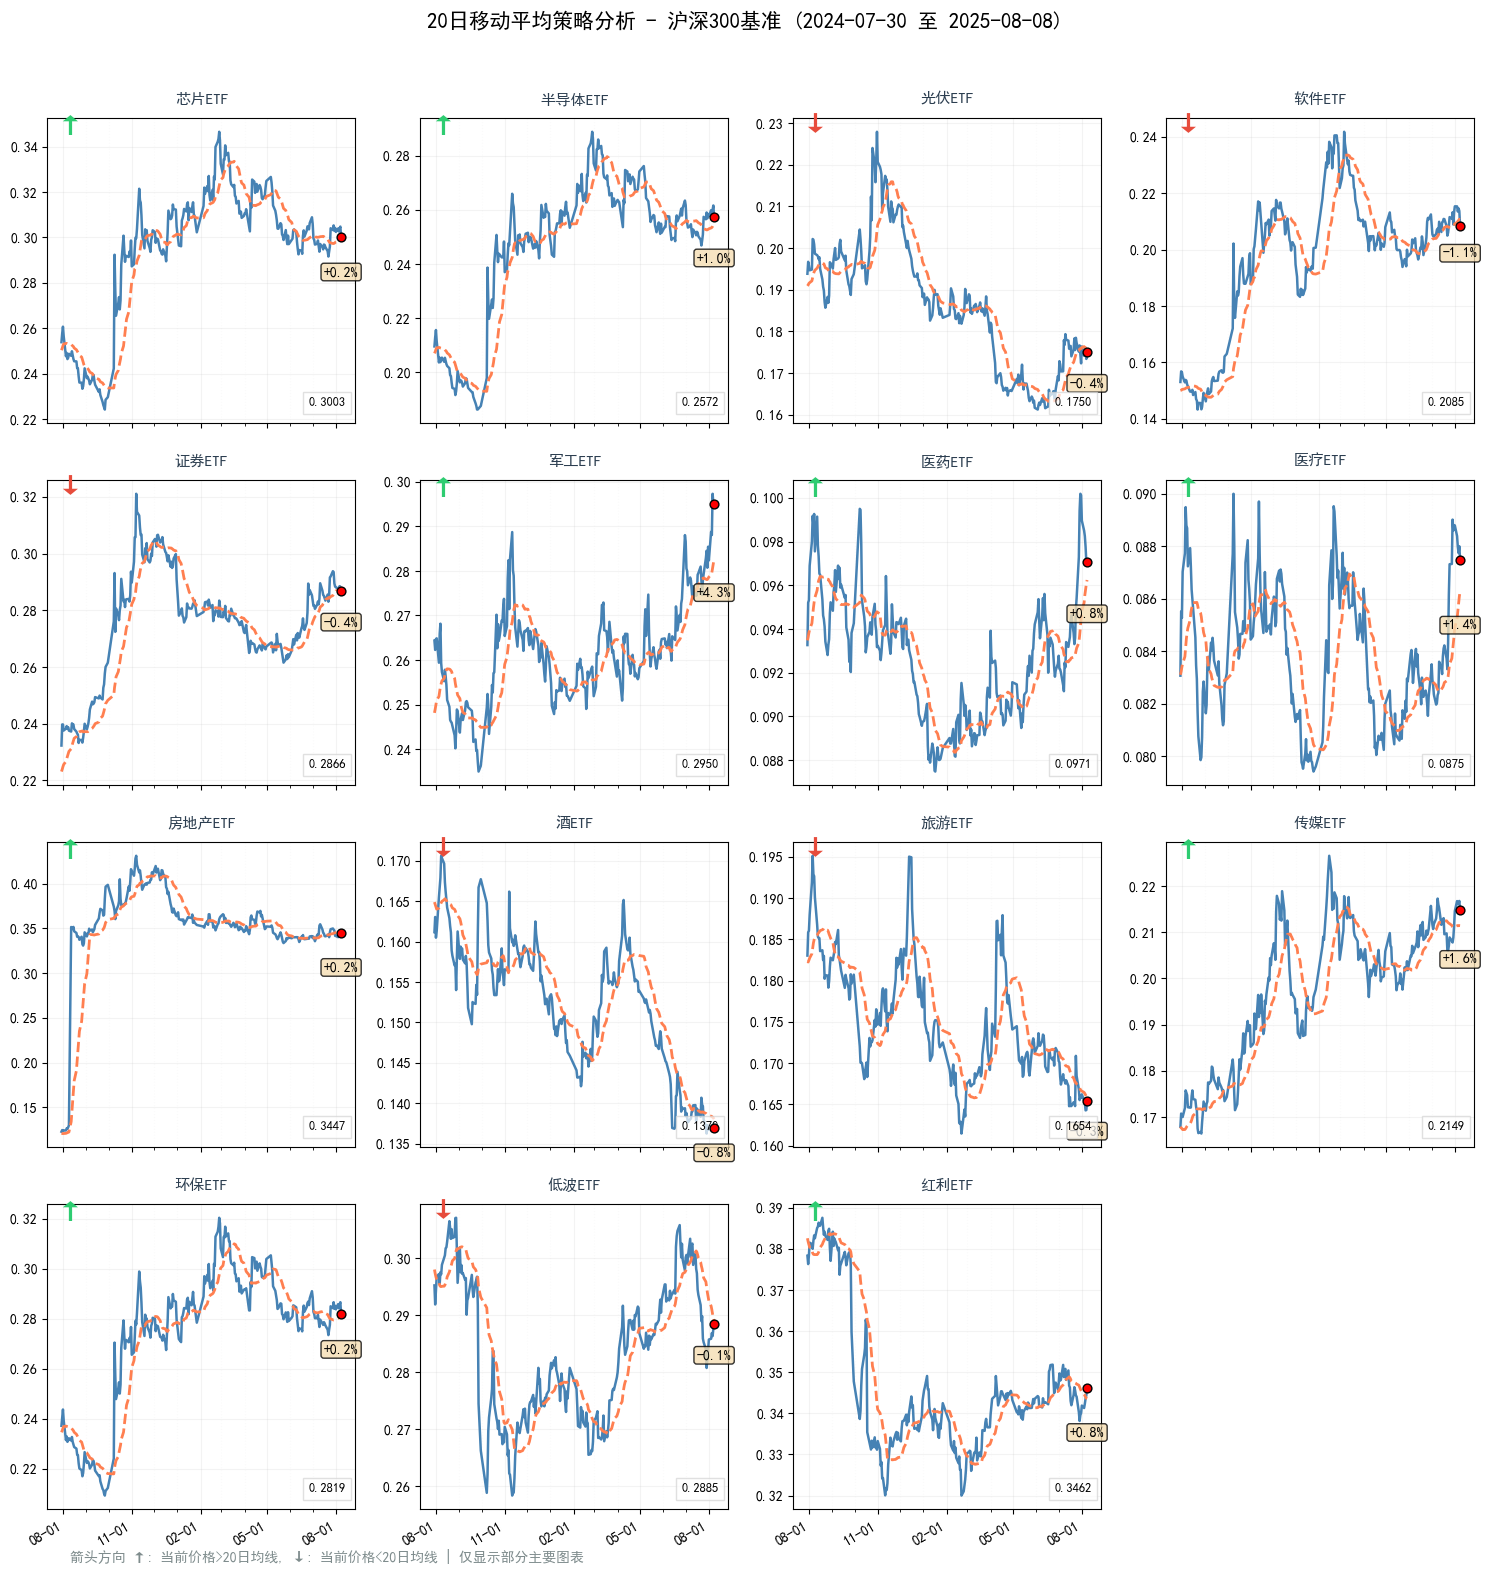


>>> 投资分析完成 <<<


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
from datetime import datetime, timedelta
from ipywidgets import interact, IntSlider, Checkbox, HBox, VBox, Button, Output, Layout
from IPython.display import display, clear_output
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# 配置Tushare
def configure_tushare(token: str = "48214906a56d6318dd8a7315f934ef249f9a033ccf82bd04a65e6ded") -> ts.pro_api:
    ts.set_token(token)
    return ts.pro_api()

pro = configure_tushare()
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

class InvestmentStrategyAnalyzer:
    """双维度投资策略分析工具"""
    def __init__(self, base_asset: str, targets: dict):
        self.base_asset = base_asset
        self.targets = targets
        self.combined = None
        self.base_name = self.targets[base_asset][1]
        self.current_chart_data = None
        self.data_status = {}  # 存储各资产数据状态
        self.data_loaded = False  # 标记数据是否已加载
        
    def load_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """加载市场数据"""
        data_dict = {}
        self.data_status = {}  # 重置状态

        # 加载基准资产
        base_code, base_name, base_type = self.targets[self.base_asset]
        base_data = self._get_asset_data(base_code, start_date, end_date, base_type, base_name)
        if base_data is None:
            raise ValueError(f"基准资产加载失败: {base_name}({base_code})")
        data_dict[self.base_asset] = base_data
        
        # 加载目标资产
        for key, (code, name, atype) in self.targets.items():
            if key == self.base_asset:
                continue
                
            asset_data = self._get_asset_data(code, start_date, end_date, atype, name)
            if asset_data is not None:
                data_dict[key] = asset_data
        
        self.combined = pd.concat({k: v['close'] for k, v in data_dict.items()}, axis=1)
        if not self.combined.empty:
            self.combined.sort_index(inplace=True)  # 确保索引有序
        self.data_loaded = True  # 标记数据已加载
        
        # 打印数据状态报告
        self._print_data_status_report()
        print(f"\n✓ 数据加载完成: 共{len(self.combined)}条记录，{len(data_dict)-1}个行业ETF")
        return self.combined
    
    def _get_asset_data(self, ts_code: str, start_date: str, end_date: str, 
                       asset_type: str, asset_name: str) -> pd.DataFrame:
        """统一数据获取接口并记录状态"""
        try:
            func = pro.fund_daily if asset_type == 'ETF' else pro.index_daily
            df = func(ts_code=ts_code, start_date=start_date, end_date=end_date)
            
            if df.empty:
                self.data_status[asset_name] = {
                    'code': ts_code,
                    'status': '未获取到数据',
                    'last_date': None,
                    'data_points': 0
                }
                print(f"⚠️ 警告: {asset_name}({ts_code}) 未获取到数据")
                return None
                
            # 数据处理
            df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            df.set_index('trade_date', inplace=True)
            df.sort_index(inplace=True)
            df = df[['close']]
            
            # 记录数据状态
            self.data_status[asset_name] = {
                'code': ts_code,
                'status': '获取成功',
                'last_date': df.index[-1].strftime('%Y-%m-%d'),
                'data_points': len(df),
                'latest_value': df['close'].iloc[-1]
            }
            
            return df
        except Exception as e:
            self.data_status[asset_name] = {
                'code': ts_code,
                'status': f'异常: {str(e)}',
                'last_date': None,
                'data_points': 0
            }
            print(f"数据获取异常: {ts_code}, {str(e)}")
            return None
            
    def _print_data_status_report(self):
        """打印详细的数据状态报告"""
        # 确定最新基准日期
        base_date = None
        if self.base_name in self.data_status and self.data_status[self.base_name].get('last_date'):
            base_info = self.data_status[self.base_name]
            base_date = datetime.strptime(base_info['last_date'], "%Y-%m-%d")
        
        print("\n===== 数据状态报告 (最新基准日期：{}) =====".format(
            base_date.strftime("%Y-%m-%d") if base_date else "N/A"
        ))
        print("| 资产名称      | 代码         | 状态       | 最新日期     | 数据量 | 最新价格 |")
        print("|---------------|--------------|------------|--------------|--------|----------|")
        
        # 打印基准资产
        if self.base_name in self.data_status:
            base_info = self.data_status[self.base_name]
            print(f"| 基准: {self.base_name:<10} | {base_info['code']:<12} | {base_info['status']:<10} | "
                  f"{base_info.get('last_date', 'N/A'):<11} | {base_info.get('data_points', 0):<6} | "
                  f"{base_info.get('latest_value', 'N/A'):<8.4f} |")
        
        # 获取除基准外的所有资产名称
        other_assets = sorted([name for name in self.data_status.keys() if name != self.base_name])
        
        for name in other_assets:
            info = self.data_status[name]
            
            # 检查数据时效性
            if base_date and info.get('last_date'):
                try:
                    asset_date = datetime.strptime(info['last_date'], "%Y-%m-%d")
                    delta_days = (base_date - asset_date).days
                    
                    if delta_days > 2:
                        status = f"落后{delta_days}天"
                    elif base_date > asset_date:
                        status = f"落后1天"
                    else:
                        status = "最新"
                except:
                    status = info['status']
            else:
                status = info['status']
                
            latest_val = info.get('latest_value', 'N/A')
            if latest_val != 'N/A' and isinstance(latest_val, float):
                formated_val = f"{latest_val:.4f}" if latest_val < 1 else f"{latest_val:.2f}"
            else:
                formated_val = str(latest_val)
            
            print(f"| {name:<13} | {info['code']:<12} | {status:<10} | "
                  f"{info.get('last_date', 'N/A'):<11} | {info.get('data_points', 0):<6} | "
                  f"{formated_val:<8} |")
    
    def calculate_ratios(self) -> "InvestmentStrategyAnalyzer":
        """计算投资标的相对于基准的比价关系"""
        if not self.data_loaded:
            raise RuntimeError("请先加载数据再计算比率")
            
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        
        for target in targets_list:
            ratio_col = f"{target}_VS_{self.base_asset}"
            self.combined[ratio_col] = self.combined[target] / self.combined[self.base_asset]
            
            # 计算不同周期的移动平均
            for window in [5, 10, 20, 30]:
                ma_col = f"{ratio_col}_MA{window}"
                self.combined[ma_col] = self.combined[ratio_col].rolling(window, min_periods=1).mean()
                
        print("✓ 比率计算完成")
        return self
    
    def create_multi_ma_strategy_chart(self):
        """创建多均线策略交互图表"""
        if not self.data_loaded:
            print("⚠️ 请先加载数据")
            return
            
        # 检查数据量是否足够
        data_size = len(self.combined)
        if data_size < 20:
            print(f"⚠️ 数据不足：目前仅有{data_size}条数据，最少需要20条数据")
            return
            
        # 创建输出区域
        out = Output(layout={'border': '1px solid silver'})
        display(out)
        
        # 创建保存PDF按钮
        pdf_btn = Button(description="保存图表为PDF", 
                         button_style='info',
                         tooltip="将当前视图保存为PDF文件",
                         layout=Layout(width='150px'))

        def save_as_pdf(b):
            """保存图表为PDF"""
            with out:
                if self.current_chart_data is None:
                    print("⚠️ 请先生成图表")
                    return
                
                # 生成文件名 - 保存在当前目录
                strategy = "多均线策略"
                start_date = self.combined.index[0].strftime("%Y%m%d")
                end_date = self.combined.index[-1].strftime("%Y%m%d")
                
                filename = f"{strategy}_{start_date}_to_{end_date}.pdf"
                filepath = os.path.join(os.getcwd(), filename)
                
                # 生成图表并保存
                fig = self.current_chart_data['figure']
                fig.savefig(filepath, bbox_inches='tight', dpi=150)
                print(f"✓ 图表已保存至: {filepath}")
        
        pdf_btn.on_click(save_as_pdf)
        
        def plot_multi_ma_strategy(
            period=min(250, data_size),
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        ):
            """绘制更清晰的多均线策略图表"""
            # 检查可用数据是否足够
            if period > data_size:
                period = data_size
                with out:
                    print(f"⚠️ 数据不足：最大分析周期调整为 {period} 天")
            
            # 收集需要显示的资产
            targets_list = [k for k in self.targets.keys() if k != self.base_asset]
            if not targets_list:
                with out:
                    print("⚠️ 没有可用的行业数据")
                return
                    
            with out:
                clear_output(wait=True)
                
                # 根据ETF数量动态调整图幅高度
                fig_height = max(4, min(len(targets_list) * 4.5, 35))
                fig = plt.figure(figsize=(14, fig_height))
                
                # 确保不请求超出可用范围的数据
                start_idx = max(0, data_size - period)
                recent_data = self.combined.iloc[start_idx:]
                latest_date = recent_data.index[-1].strftime("%Y-%m-%d")
                
                # 获取资产名称列表
                asset_names = [self.targets[asset][1] for asset in targets_list]
                
                for idx, (asset, asset_name) in enumerate(zip(targets_list, asset_names)):
                    ratio_col = f"{asset}_VS_{self.base_asset}"
                    
                    # 动态调整子图布局
                    rows = (len(targets_list) + 1) // 2
                    cols = 2 if len(targets_list) > 1 else 1
                    ax = plt.subplot(rows, cols, idx+1)
                    
                    # 绘制比价曲线
                    ax.plot(
                        recent_data.index,
                        recent_data[ratio_col],
                        color='gray',
                        linewidth=1.0,
                        alpha=0.4,
                        zorder=1
                    )
                    
                    # 均线设置
                    ma_settings = [
                        (show_ma5, 5, 'orangered'),
                        (show_ma10, 10, 'royalblue'),
                        (show_ma30, 30, 'purple')
                    ]
                    
                    # 绘制选择的均线
                    for show, window, color in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ax.plot(
                                recent_data.index,
                                recent_data[ma_col],
                                color=color,
                                linewidth=2.2,
                                zorder=2
                            )
                    
                    # 图表美化
                    title_color = 'dimgray'
                    ax.set_title(asset_name, fontsize=12, weight='bold', color=title_color)
                    ax.grid(True, which='major', alpha=0.15, linestyle='-')
                    
                    # 设置日期格式器和定位器
                    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
                    # 根据数据范围动态设置月份间隔
                    date_range = recent_data.index[-1] - recent_data.index[0]
                    month_interval = max(1, min(6, date_range.days // 30))
                    locator = mdates.MonthLocator(interval=month_interval)
                    ax.xaxis.set_major_locator(locator)
                    
                    # 设置次要网格线为每日（但不显示刻度）
                    ax.xaxis.set_minor_locator(mdates.DayLocator())
                    ax.grid(True, which='minor', alpha=0.05, linestyle=':')
                    
                    # 计算相对位置信息
                    current_val = recent_data[ratio_col].iloc[-1]
                    above_ma_count = 0
                    
                    # 计算各均线位置
                    for show, window, color in ma_settings:
                        if show:
                            ma_col = f"{ratio_col}_MA{window}"
                            ma_val = recent_data[ma_col].iloc[-1]
                            if current_val > ma_val:
                                above_ma_count += 1
                    
                    # 添加简单位置提示
                    trend_text = "↑↑" if above_ma_count >= 2 else "↑" if above_ma_count == 1 else "↓"
                    box_color = 'lightgreen' if above_ma_count >= 2 else 'lightyellow' if above_ma_count == 1 else 'lightpink'
                    
                    ax.annotate(
                        f"{trend_text} {above_ma_count}/3",
                        xy=(0.97, 0.95),
                        xycoords='axes fraction',
                        ha='right',
                        va='top',
                        fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.5', fc=box_color, ec='none', alpha=0.8)
                    )
                
                # 添加图表说明
                date_range_text = f"{recent_data.index[0].strftime('%Y-%m-%d')} 至 {recent_data.index[-1].strftime('%Y-%m-%d')} ({period}个交易日)"
                plt.suptitle(
                    f"行业ETF相对{self.base_name}表现趋势分析",
                    fontsize=14,
                    weight='bold',
                    y=0.98
                )
                
                # 添加全局说明
                plt.figtext(0.05, 0.01, 
                            f"{date_range_text} | 提示：↑↑/↑/↓ 表示当前价格位于均线上方的比例 (3/3、2/3、1/3)",
                            ha="left", fontsize=9, style='italic', color='slategrey')
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.97])
                plt.show()
                print(f"✓ 图表已生成! 数据周期: {period}天，日期范围: {date_range_text}")
                self.current_chart_data = {
                    'period': period,
                    'figure': fig,
                    'settings': {'ma5': show_ma5, 'ma10': show_ma10, 'ma30': show_ma30}
                }
        
        # 创建控制面板
        max_period = min(500, data_size)
        period_slider = IntSlider(min=60, max=max_period, step=5, value=min(250, max_period), 
                                 description='分析周期:', layout=Layout(width='300px'))
        
        controls = VBox([
            HBox([
                period_slider,
                pdf_btn
            ]),
            HBox([
                Checkbox(value=True, description='5日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='10日均线', layout=Layout(width='100px')),
                Checkbox(value=True, description='30日均线', layout=Layout(width='100px'))
            ])
        ])
        
        # 显示控件并设置初始显示
        display(controls)
        
        # 初始绘制图表
        plot_multi_ma_strategy(
            period=period_slider.value,
            show_ma5=True,
            show_ma10=True,
            show_ma30=True
        )
        
        # 设置交互函数
        interact(
            plot_multi_ma_strategy,
            period=period_slider,
            show_ma5=controls.children[1].children[0],
            show_ma10=controls.children[1].children[1],
            show_ma30=controls.children[1].children[2]
        )
    
    def generate_20ma_strategy(self):
        """生成20日均线策略报告"""
        if not self.data_loaded:
            print("⚠️ 请先加载数据")
            return
            
        # 检查数据量是否足够
        data_size = len(self.combined)
        if data_size < 20:
            print(f"⚠️ 数据不足：目前仅有{data_size}条数据，最少需要20条数据")
            return
            
        print(">>> 生成20日均线策略报告 <<<")
        targets_list = [k for k in self.targets.keys() if k != self.base_asset]
        num_targets = len(targets_list)
        
        if num_targets == 0:
            print("⚠️ 没有可分析的目标资产")
            return None
            
        # 使用实际可用数据的最后部分
        period = min(250, data_size)
        data = self.combined.iloc[-period:]
        start_date = data.index[0].strftime("%Y-%m-%d")
        end_date = data.index[-1].strftime("%Y-%m-%d")
        
        # 动态设置布局
        row_height = 3.8
        max_rows = 5  # 最多5行
        max_cols = 4  # 每行最多4列
        cols = min(max_cols, num_targets)
        rows = min(max_rows, (num_targets + cols - 1) // cols)
        
        # 计算图表高度
        fig_height = min(4 * rows, 18)  # 限制最大高度为18英寸
        
        # 创建图表
        fig = plt.figure(figsize=(15, fig_height))
        
        # 为每个资产创建子图
        for idx, asset in enumerate(targets_list[:max_rows * max_cols]):  # 限制最多显示20个图表
            ratio_col = f"{asset}_VS_{self.base_asset}"
            asset_name = self.targets[asset][1]
            
            ax = plt.subplot(rows, cols, idx + 1)
            
            # 绘制比价曲线
            ax.plot(
                data.index,
                data[ratio_col],
                color='steelblue',
                linewidth=1.8
            )
            
            # 绘制20日均线
            ma_col = f"{ratio_col}_MA20"
            ax.plot(
                data.index,
                data[ma_col],
                color='coral',
                linewidth=2.0,
                linestyle='--'
            )
            
            # 标记最新点
            latest_index = data.index[-1]
            ax.scatter(
                latest_index,
                data[ratio_col].iloc[-1],
                color='red',
                s=40,
                zorder=5,
                edgecolor='black'
            )
            
            # 图表元素
            current_val = data[ratio_col].iloc[-1]
            current_ma = data[ma_col].iloc[-1] if ma_col in data.columns else current_val
            above_ma = current_val > current_ma
            
            # 计算偏差百分比
            if current_ma > 0:
                deviation_pct = ((current_val - current_ma) / current_ma) * 100
            else:
                deviation_pct = 0
            
            # 添加位置指示器
            arrow_symbol = "↑" if above_ma else "↓"
            arrow_color = "#2ecc71" if above_ma else "#e74c3c"  # 柔和的绿色和红色
            
            # 添加位置指示器
            ax.annotate(
                arrow_symbol,
                xy=(0.03, 0.95),
                xycoords='axes fraction',
                ha='left',
                fontsize=18,
                fontweight='bold',
                color=arrow_color
            )
            
            # 添加偏离度标注
            ax.annotate(
                f"{'+' if deviation_pct >= 0 else ''}{deviation_pct:.1f}%",
                xy=(latest_index, current_ma),
                xytext=(0, -20),
                textcoords="offset points",
                ha='center',
                va='top',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", fc="wheat", alpha=0.8)
            )
            
            # 添加当前值标注
            ax.annotate(
                f"{current_val:.4f}",
                xy=(0.97, 0.05),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='lightgray')
            )
            
            ax.set_title(asset_name, fontsize=11, pad=10, fontweight='bold', color='#2c3e50')
            ax.grid(True, linestyle='-', alpha=0.15)
            
            # 设置日期刻度 - 避免用户警告
            # 根据数据范围动态设置间隔
            date_range_days = (data.index[-1] - data.index[0]).days
            locator_interval = max(1, min(3, date_range_days // 60))  # 每1-3个月一个刻度
            
            # 设置主要刻度为每月
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
            
            # 设置次要刻度为每周但不显示标签
            ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
            ax.grid(True, which='minor', alpha=0.05, linestyle=':')
            
            # 旋转刻度标签
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
            
            # 只对底部的图表显示x轴标签
            bottom_rows = range((rows - 1) * cols, rows * cols)
            if idx not in bottom_rows:
                plt.setp(ax.get_xticklabels(), visible=False)
        
        # 添加全局标题
        plt.suptitle(
            f"20日移动平均策略分析 - {self.base_name}基准 ({start_date} 至 {end_date})",
            fontsize=15,
            fontweight='bold',
            y=0.99
        )
        
        # 添加说明
        plt.figtext(0.05, 0.02, 
                   f"箭头方向 ↑: 当前价格>20日均线, ↓: 当前价格<20日均线 | 仅显示部分主要图表",
                   style='italic', color='#7f8c8d', fontsize=10)
        
        plt.tight_layout(rect=[0, 0.02 if data_size > 100 else 0, 1, 0.97])
        
        # 保存报告
        filename = f"20MA_{start_date}_to_{end_date}.pdf"
        filepath = os.path.join(os.getcwd(), filename)
        fig.savefig(filepath, bbox_inches='tight')
        print(f"✓ 20日均线策略报告已保存至: {filepath}")
        
        plt.show()

# 主执行流程
if __name__ == "__main__":
    # 1. 参数配置
    start_date = (datetime.now() - timedelta(days=365*2)).strftime('%Y%m%d')  # 获取2年数据
    end_date = datetime.now().strftime('%Y%m%d')
    
    print(f"数据请求范围: {start_date} 至 {end_date}")
    
    # 2. 资产配置（沪深300ETF作为基准） - 精简集合
    targets = {
        'HS300': ('510300.SH', '沪深300', 'ETF'),
       'CHIP_ETF': ('159995.SZ', '芯片ETF', 'ETF'),
        'SEMIS': ('512480.SH', '半导体ETF', 'ETF'),
        'PV_ETF': ('515790.SH', '光伏ETF', 'ETF'),
        'SOFTWARE_ETF': ('515230.SH', '软件ETF', 'ETF'),
        'SECURITY_ETF': ('512880.SH', '证券ETF', 'ETF'),
        'MILITARY_ETF': ('512660.SH', '军工ETF', 'ETF'),
        'MED_ETF': ('512010.SH', '医药ETF', 'ETF'),
        'HC': ('512170.SH', '医疗ETF', 'ETF'),
        'REALSTATE_ETF': ('512200.SH', '房地产ETF', 'ETF'),
        'WINE_ETF': ('512690.SH', '酒ETF', 'ETF'),
        'TRAVEL_ETF': ('562510.SH', '旅游ETF', 'ETF'),
        'MEDIA_ETF': ('512980.SH', '传媒ETF', 'ETF'),
        'ESG_ETF': ('512760.SH', '环保ETF', 'ETF'),
        'DI_DIVIDEND': ('512890.SH', '低波ETF', 'ETF'),
        'DIVIDEND_ETF': ('515180.SH', '红利ETF', 'ETF')
    }
    
    # 3. 初始化分析器
    print(">>> 启动投资分析系统 <<<")
    analyzer = InvestmentStrategyAnalyzer(base_asset='HS300', targets=targets)
    
    try:
        # 4. 加载数据
        print("\n>>> 加载市场数据 <<<")
        analyzer.load_data(start_date, end_date)
        analyzer.calculate_ratios()
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        exit(1)
    
    # 5. 生成多均线交互式图表
    try:
        print("\n>>> 创建多均线策略交互视图 <<<")
        analyzer.create_multi_ma_strategy_chart()
    except Exception as e:
        print(f"多均线策略生成失败: {str(e)}")
    
    # 6. 生成20日均线策略报告
    try:
        print("\n>>> 生成20日均线交易策略 <<<")
        analyzer.generate_20ma_strategy()
    except Exception as e:
        print(f"20日均线策略生成失败: {str(e)}")
    
    print("\n>>> 投资分析完成 <<<")
